In [134]:
#import useful libraries for the project
%pylab inline
%matplotlib inline
import os
import cv2
import gzip
import time
import warnings
import itertools
import numpy as np
from PIL import Image
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import bernoulli
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [136]:
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
img_dir = os.path.join(BASE_DIR, "Training Pictures")

In [191]:
current_id = 0
label_ids = {}
y_label = []
X_images = []
y = []
X = []
for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".jpeg"):
            path = os.path.join(root, file)
            label = os.path.basename(os.path.dirname(path)).replace(" ", "-").lower()
            if not label in label_ids:
                label_ids[label] = current_id
                current_id += 1
            id_ = label_ids[label]
            pil_image = Image.open(path)
            y_label.append(label)
            y.append(id_)
            X_images.append(path)
            X.append(np.array(pil_image))
            pil_image.close()

In [192]:
print(X.shape)

AttributeError: 'list' object has no attribute 'shape'

In [138]:
print("The size of x is {}.".format(len(X)))
print("The size of y is {}.".format(len(y)))

The size of x is 5599.
The size of y is 5599.


In [166]:
def display_image(cls):
    cls_index = []
    for index1, item1 in enumerate(cls):
        if item1 in y_label:
            cls_index.append(y_label.index(item1))
    for index, item in enumerate(cls_index):
        fig, ax = plt.subplots(figsize=(2, 2))
        fig.subplots_adjust(hspace= 0.2, wspace= 0.2)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(mpimg.imread(X_images[item]), cmap = 'gray')
        plt.xlabel("{} - ".format(y_label[item]) + "class : {}".format(y[item]))

In [167]:
print("The unique classes are {}".format(np.unique(y_label)))

The unique classes are ['0' '1' '2' '3']


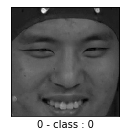

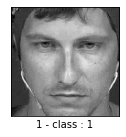

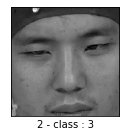

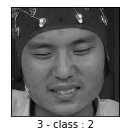

In [168]:
cls = ['0', '1', '2', '3']
display_image(cls)

In [112]:
def get_emotion(num_class):
    if num_class == 0:
        return 'happy'
    elif num_class == 1:
        return 'sad'
    elif num_class == 2:
        return 'fear'
    elif num_class == 3:
        return 'surprise'
    elif num_class == 4:
        return 'neutral'
    elif num_class == 5:
        return 'angry'
    elif num_class == 6:
        return 'disgust'

In [143]:
get_emotion(y[2])

'happy'

In [169]:
testRatio = 0.2    # if 1000 images split will 200 for testing
validationRatio = 0.2 # if 1000 images 20% of remaining 800 will be 160 for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

In [189]:

X_train[111].shape

(342, 342)

In [ ]:
print("Data Shapes")
print("Train",end = "");print(X_train[1].shape ,np.asarray(y_train).shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)

In [149]:
# Dimensions of the data

# We know that images are 48 pixels in each dimension
in_height = 48
in_width = 48

# Images are stored in one-dimensional arrays of this length
image_size_flat = in_height * in_width

# Tuple with height and width of images used to reshape arrays
image_shape = (in_height, in_width)

# Classes info
classes = np.unique(y_label)

# Number of classes
num_classes = len(classes)

# Number of colour channels for the images: 1 channel for gray-scale
# Channels mean number of primary colors
num_channels = 1

In [150]:
# Placeholder variables

# Placeholder variable for the input images
x = tf.placeholder(tf.float32, shape=[None, image_size_flat])

# Reshape 'x'
x_image = tf.reshape(x, shape=[-1, in_height, in_width, num_channels])

# Placeholder variable for the true labels associated with the images
y_true = tf.placeholder(tf.float32, shape=[None, num_classes])

# We could also have a placeholder variable for the class-number,
# but we will instead calculate it using argmax
y_true_cls = tf.argmax(y_true, dimension=1)

In [151]:
print(y_true_cls)

Tensor("ArgMax_3:0", shape=(?,), dtype=int64)


In [152]:
# Convolutional Layer 1

# Convolution filters are 3 x 3 pixels
filter_height_1 = 3
filter_width_1 = 3

# There are 8 of these filters
num_filters_1 = 8

# Convolutional Layer 2

# Convolution filters are 3 x 3 pixels
filter_height_2 = 3 
filter_width_2 = 3

# There are 16 of these filters
num_filters_2 = 16

# Convolutional Layer 3

# Convolution filters are 3 x 3 pixels
filter_height_3 = 3
filter_width_3 = 3

# There are 32 of these filters
num_filters_3 = 32

# Convolutional Layer 4

# Convolution filters are 3 x 3 pixels
filter_height_4 = 3
filter_width_4 = 3

# There are 64 of these filters
num_filters_4 = 64

# Convolutional Layer 5

# Convolution filters are 3 x 3 pixels
filter_height_5 = 3
filter_width_5 = 3

# There are 128 of these filters
num_filters_5 = 128

# Fully-connected layer
# Number of neurons in fully-connected layer
fc_size = 128

In [153]:
# Non-trainable filters initialized with distribution
# of Bernoulli as in article and then it's non-trainable
def new_weights_non_trainable(h,
                              w,
                              num_input,
                              num_output,
                              sparsity=0.5):
    
    # Number of elements
    num_elements = h * w * num_input * num_output
    
    # Create an array with n number of elements
    array = np.arange(num_elements)
    
    # Random shuffle it
    np.random.shuffle(array)
    
    # Fill with 0
    weight = np.zeros([num_elements])
    
    # Get number of elements in array that need be non-zero
    ind = int(sparsity * num_elements + 0.5)
    
    # Get it piece as indexes for weight matrix
    index = array[:ind]
  
    for i in index:
        # Fill those indexes with bernoulli distribution
        # Method rvs = random variates
        weight[i] = bernoulli.rvs(0.5)*2-1

    # Reshape weights array for matrix that we need
    weights = weight.reshape(h, w, num_input, num_output)
    
    # print weights

    return weights

In [154]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [155]:
def new_biases(length):
    # Equivalent to y intercept
    # Constant value carried over across matrix math
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [156]:
# Think of it as one block

def new_LBC_layer(input,              # The previous layer
                  filter_height,      # Height of each filter
                  filter_width,       # Width of each filter
                  in_channels,        # Num. channels in prev. layer
                  out_channels,       # # Number of filters
                  use_pooling=True):  # Use 2x2 max-pooling
    
    # The out_channels of the previous layer are the in_channels of the next layer

    # Shape of the filter-weights for the convolution
    # This format is determined by the TensorFlow API
    # shape = [filter_height, filter_width, in_channels, out_channels]

    # Non-trainable filters
    anchor_weights = tf.Variable(new_weights_non_trainable(h=filter_height,
                                                           w=filter_width,
                                                           num_input=in_channels,
                                                           num_output=out_channels).astype(np.float32),
                                                           trainable=False)
    
    # Difference Maps
    difference_maps = tf.nn.conv2d(input=input,
                                   filter=anchor_weights,
                                   strides=[1, 1, 1, 1],
                                   padding='SAME')
    
    # Non-linear unit is ReLU, as in article
    
    # Bit Maps
    bit_maps = tf.nn.relu(difference_maps)
    
    # Set of learnable linear weights is a convolution with 1x1 kernels,
    # without bias and without non-linear unit

    shape = [1, 1, out_channels, 1]
    
    weights = new_weights(shape)

    # Feature Maps
    feature_maps = tf.nn.conv2d(input=bit_maps, 
                                filter=weights,
                                strides=[1, 1, 1, 1],
                                padding='SAME')

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window
        feature_maps = tf.nn.max_pool(value=feature_maps,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # We will plot them later
    return feature_maps, anchor_weights, weights

In [ ]:
# Convolutional layer 1 
feature_maps_conv_1, anchor_weights_conv_1, weights_conv_1 = new_LBC_layer(input=X_train,
                                                                           filter_height=filter_height_1,
                                                                           filter_width=filter_width_1,
                                                                           in_channels=num_channels,
                                                                           out_channels=num_filters_1,
                                                                           use_pooling=False)

In [ ]:
feature_maps_conv_1

In [158]:
anchor_weights_conv_1

<tf.Variable 'Variable:0' shape=(3, 3, 1, 8) dtype=float32_ref>

In [35]:
weights_conv_1

<tf.Variable 'Variable_1:0' shape=(1, 1, 8, 1) dtype=float32_ref>

In [37]:
# Convolutional layer 2
feature_maps_conv_2, anchor_weights_conv_2, weights_conv_2 = new_LBC_layer(input=feature_maps_conv_1,
                                                                           filter_height=filter_height_2,
                                                                           filter_width=filter_width_2,
                                                                           in_channels=1,
                                                                           out_channels=num_filters_2,
                                                                           use_pooling=False)

In [38]:
# Convolutional layer 3
feature_maps_conv_3, anchor_weights_conv_3, weights_conv_3 = new_LBC_layer(input=feature_maps_conv_2,
                                                                           filter_height=filter_height_3,
                                                                           filter_width=filter_width_3,
                                                                           in_channels=1,
                                                                           out_channels=num_filters_3,
                                                                           use_pooling=False)

In [39]:
# Convolutional layer 4
feature_maps_conv_4, anchor_weights_conv_4, weights_conv_4 = new_LBC_layer(input=feature_maps_conv_3,
                                                                           filter_height=filter_height_4,
                                                                           filter_width=filter_width_4,
                                                                           in_channels=1,
                                                                           out_channels=num_filters_4,
                                                                           use_pooling=False)

In [40]:
# Convolutional layer 5
feature_maps_conv_5, anchor_weights_conv_5, weights_conv_5 = new_LBC_layer(input=feature_maps_conv_4,
                                                                           filter_height=filter_height_5,
                                                                           filter_width=filter_width_5,
                                                                           in_channels=1,
                                                                           out_channels=num_filters_5,
                                                                           use_pooling=True)

In [41]:
def flatten_layer(layer):
    # Get the shape of the input layer
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, image_height, image_width, num_channels]

    # The number of features is: image_height * image_width * num_channels
    # We can use a function from TensorFlow to calculate this
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features]
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, image_height * image_width * num_channels]

    # Return both the flattened layer and the number of features
    return layer_flat, num_features

In [42]:
layer_flat, num_features = flatten_layer(feature_maps_conv_5)

In [43]:
def new_fc_layer(input,          # The previous layer
                 num_inputs,     # Num. inputs from prev. layer
                 num_outputs,    # Num. outputs
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [44]:
# Fully-Connected Layer 1
layer_fc_1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [45]:
# Fully-Connected Layer 2 (Classes)
layer_fc_2 = new_fc_layer(input=layer_fc_1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [46]:
# Normalization of class-number output
y_pred = tf.nn.softmax(layer_fc_2)

In [47]:
# The class-number is the index of the largest element
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [48]:
# Cross-entropy 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc_2,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [49]:
# Average of the cross-entropy
loss = tf.reduce_mean(cross_entropy)

In [50]:
# Optimization method
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)

In [51]:
# Measures of performance
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [52]:
# Calculates the total number of learning parameters
total_parameters = 0

for variable in tf.trainable_variables():
    variable_parameters = 1
    
    for i in variable.get_shape():
        variable_parameters *= i.value
        
    total_parameters += variable_parameters

print("\nTotal number of learning parameters in the network model: %d" % total_parameters)


Total number of learning parameters in the network model: 74620


In [53]:
# Saver-object which is used for storing and retrieving
# all the variables of the TensorFlow graph
saver = tf.train.Saver()

In [73]:
epochs_completed = 0
index_in_epoch = 0
num_examples = len(data_train_images)

# Serve data by batches
def next_batch(batch_size):
    
    global data_train_images
    global data_train_labels 
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += train_batch_size
    
    # When all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # Finished epoch
        epochs_completed += 1
        
        # Shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        
        data_train_images = data_train_images[perm]
        data_train_labels = data_train_labels [perm]
        
        # Start next epoch
        start = 0
        index_in_epoch = train_batch_size
        
        assert train_batch_size <= num_examples
    end = index_in_epoch
    
    return data_train_images[start:end], data_train_labels[start:end]

In [74]:
# TensorFlow session
# Verify your GPU - Find out which device is use
session = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:



In [75]:
# Restore or initialize variables

# We therefore save checkpoints during training so we can continue training at
# another time (e.g. during the night), and also for performing analysis later
# without having to train the neural network every time we want to use it

# If you want to restart the training of the neural network, you have to delete
# the checkpoints first

# Directory used for the checkpoints
save_dir = 'Checkpoints/JAFFE/'

# Create the directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# Base-filename for the checkpoints
save_path = os.path.join(save_dir, 'JAFFE')

# First try to restore the latest checkpoint. This may fail and raise an exception e.g.
# if such a checkpoint does not exist, or if you have changed the TensorFlow graph

try:
    print("Trying to restore last checkpoint...\n")

    # Find the latest checkpoint - if any
    last_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint
    saver.restore(session, save_path=last_checkpoint_path)

    # If we get to this point, the checkpoint was successfully loaded
    print("\nRestored checkpoint from" + last_checkpoint_path)

except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph
    print("\nFailed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint...


Failed to restore checkpoint. Initializing variables instead.


In [76]:
train_batch_size = 128

In [77]:
# Counter for total number of iterations performed so far
total_iterations = 0

In [128]:
# Helper-function for performing a number of optimization iterations so as to gradually
# improve the variables of the network layers

# In each iteration, a new batch of data is selected from the training-set and then
# TensorFlow executes the optimizer using those training samples

# The progress is printed every 100 iterations
def training(num_iterations):
    
    # Ensure we update the global variable rather than a local copy
    global total_iterations

    # Start-time used for printing time-usage below
    start_time = time.time()
    
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        
        # Get a batch of training examples:
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images                             
        x_batch, y_true_batch = next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        
        # Run the optimizer using this batch of training data
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer
        session.run(optimizer, feed_dict= feed_dict_train)

        # Print status every 100 iterations
        if i % 100 == 0:
            # Calculate the accuracy on the training-set
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it
            print(msg.format(i + 1, acc))

        # Save a checkpoint to disk every 1000 iterations
        if i % 1000 == 0:
            # Save all variables of the TensorFlow graph to a checkpoint
            # Append the global_step counter to the filename so we save
            # the last several checkpoints
            saver.save(session, save_path=save_path, global_step=i)

            print("Saved checkpoint.")
            
    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [129]:
# Helper-function to plot example errors
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set

    # Negate the boolean array
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified
    images = data_test_images[incorrect]
    
    # Get the predicted classes for those images
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images
    cls_true = data_test_cls[incorrect]
    
    # Plot the first 9 images
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [130]:
# Helper-function to plot confusion matrix
def plot_confusion_matrix(cls_pred):
    # This is called from test() below

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set

    # Get the true classifications for the test-set
    cls_true = data_test_cls
    
    # Get the confusion matrix using sklearn
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text
    # print(cm)

    # Plot the confusion matrix as an image
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
   
    # Make various adjustments to the plot
    plt.imshow(cm, interpolation='nearest', cmap='Greys')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    plt.show()

In [131]:
# Split the test-set into smaller batches of this size
test_batch_size = 32

In [132]:
# Helper-function for showing the performance
def test(show_example_errors=False,
         show_confusion_matrix=False):

    # Number of images in the test-set
    num_test = len(data_test_images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches
    # We will just iterate through all the batches

    # The starting index for the next batch is denoted i
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j
        images = data_test_images[i:j, :]

        # Get the associated labels.
        labels = data_test_labels[i:j, :]

        # Create a feed-dict with these images and labels
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch
        i = j

    # Convenience variable for the true class-numbers of the test-set
    cls_true = data_test_cls

    # Create a boolean array whether each image is correctly classified
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images
    # When summing a boolean array, False means 0 and True means 1
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set
    acc = float(correct_sum) / num_test

    # Print the accuracy
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired
    if show_example_errors:
        print("\nExample errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)